# Weighted Estimation for Stock Price
# First Step: Import Data

In [28]:
#Initialization
import sys
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model


import warnings


warnings.simplefilter("ignore")


In [29]:
import fix_yahoo_finance as yf  


Stocks = ['AAPL', 'FB','GOOGL','AMZN']
data = yf.download(Stocks,'2016-01-01','2018-06-01')

[*********************100%***********************]  4 of 4 downloaded


In [30]:
data

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 608 (major_axis) x 4 (minor_axis)
Items axis: Open to Volume
Major_axis axis: 2016-01-04 00:00:00 to 2018-06-01 00:00:00
Minor_axis axis: AAPL to GOOGL

# Second Step: Amazon stock price

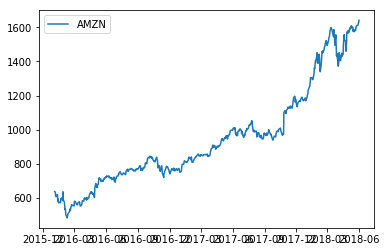

In [31]:
St = data['Adj Close']['AMZN']
plt.plot(St)
plt.legend(['AMZN'])
plt.show()

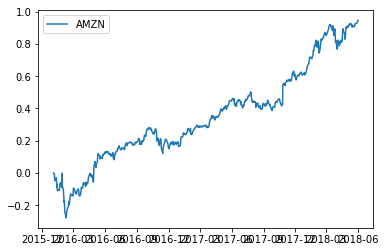

In [32]:
# Take the log price
LogSt = np.log(St) - np.log(St[0])
plt.plot(LogSt)
plt.legend(['AMZN'])
plt.show()

# Third Step: Prediction of different models （Using last N_day=30 days data）

Here, we use 4 basic prediction method: N day return, OU model, moving average and autoregression. In addition we use last N_day=30 days data to predict the next day log price.

We assume 
\begin{equation*}
N=\mbox{N_day}, LogSt=Log Price
\end{equation*}

N day return:
\begin{equation*}
Prediction = \frac{LogSt[t] - LogSt[t-N+1]}{N-1} + LogSt[t]
\end{equation*}

OU model:
\begin{equation*}
Prediction=\lambda(LogSt[t] - \mu) +  LogSt[t] 
\end{equation*}
where we need to estimate $\lambda$ and $\mu$

Moving Average:
\begin{equation*}
Prediction = \frac{\sum_{i=t-N+1}^tLogSt[i]}{N}
\end{equation*}

Autoregression: AR(q)

N-day return estimation




In [33]:
N_day = 30
T = len(LogSt)
S_nd = np.zeros(T-N_day)

for t in range(N_day-1,T-1):
    S_nd[t-N_day+1] = (LogSt[t] - LogSt[t-N_day+1])/(N_day-1) + LogSt[t]

Mean reversion - OU model

In [34]:
S_ou = np.zeros(T-N_day)
for t in range(N_day-1,T-1):
    train = np.array(LogSt[t-N_day+1:t])
    #fit linear regression
    y = train[1:] - train[:-1]
    x = train[:-1]
    param = np.polyfit(x,y,1)
    beta = -param[0]
    mu = param[1]/beta
    dx = beta*(mu - train[-1])
    S_ou[t-N_day+1] = LogSt[t] + dx


Moving Average and Autoregression

In [35]:
X = LogSt
MA=X.rolling(window=N_day+1,center=False).mean()
MA.columns=['MA']


# AutoRegression


AR = pd.Series([['NaN']]*N_day)
AR.index=X.index[0:N_day]
for i in range(len(X)-N_day):
    train=X[i:i+N_day]
    test=X[N_day]
    model = smt.AR(train)
    model_fit = model.fit()
    s=pd.Series(model_fit.predict(start=len(train),end=len(train)))
    s.columns=['AR']
    s.index=X.index[i+N_day:i+N_day+1]
    AR=AR.append(s)
    
#AR=pd.Series(AR)   
S_ma = np.array(MA[N_day:])
S_ar = np.array(AR[N_day:])




We plot the prediction and errors over time.

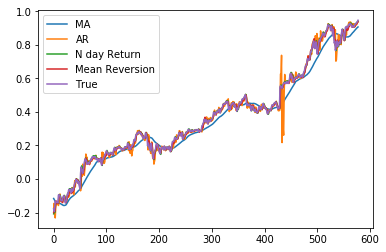

In [36]:
#Prediction
plt.plot(S_ma)
plt.plot(S_ar)
plt.plot(S_nd)
plt.plot(S_ou)
plt.plot(np.array(LogSt[N_day:]))
plt.legend(['MA','AR','N day Return', 'Mean Reversion','True'])
plt.show()

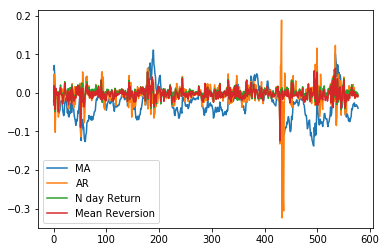

In [37]:
#Difference between prediction and true data
plt.plot(S_ma-np.array(LogSt[N_day:]))
plt.plot(S_ar-np.array(LogSt[N_day:]))
plt.plot(S_nd-np.array(LogSt[N_day:]))
plt.plot(S_ou-np.array(LogSt[N_day:]))
plt.legend(['MA','AR','N day Return', 'Mean Reversion'])
plt.show()

# Fourth Step: Weighted Estimation Based on Regret

Now that we have predictions by 4 different methods, we are going to give a aggregate prediction, which is the weighted average of those 4 different methods. The weights system is based on the regret for 4 predictions, which could be written as following.

\begin{equation*}
Weight_i = \frac{\exp(-Regret_i)}{\sum_k exp(-Regret_k)} 
\end{equation*}
We propose two regrets here. 

The first one is $L_2$ norm of prediction errors. 

\begin{equation*}
Regret_i=||Errors||_2
\end{equation*}

The second one is the investment loss: if the prediction is higher than today's price we long the stock, else we short the stock. Then we treat the loss as our Regret. The update for regret could be written as following.

\begin{equation*}
New Regret_i = Regret_i -Sign(Prediction - TodayLogPrice)*ActualPriceGrowth
\end{equation*}

The First Regret

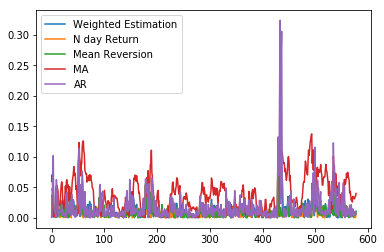

Average regret of Weighted Estimation is 0.000355030599209
Average regret of N day Return is 0.00023210722027
Average regret of Mean Reversion is 0.000241929083269
Average regret of Moving Average is 0.00237965555853
Average regret of AutoRegression is 0.001123920782532186


In [38]:
WEst = np.zeros(T-N_day)
reg_ar = [0]
reg_ma = [0]
reg_nd = [0]
reg_ou = [0]
w_nd=[]
w_ou=[]
w_ar=[]
w_ma=[]
for t in range(T-N_day):
    w_nd.append(np.exp(-reg_nd[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    w_ou.append(np.exp(-reg_ou[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    w_ar.append(np.exp(-reg_ar[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    w_ma.append(np.exp(-reg_ma[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    WEst[t] = w_nd[t]*S_nd[t] + w_ou[t]*S_ou[t]+w_ar[t]*S_ar[t] + w_ma[t]*S_ma[t]
    #use square loss as the regret
    reg_nd += (S_nd[t] - X[t+N_day])**2
    reg_ou += (S_ou[t] - X[t+N_day])**2
    reg_ar += (S_ar[t] - X[t+N_day])**2
    reg_ma += (S_ma[t] - X[t+N_day])**2

plt.plot(abs(WEst-np.array(X[N_day:])))
plt.plot(abs(S_nd-np.array(X[N_day:])))
plt.plot(abs(S_ou-np.array(X[N_day:])))
plt.plot(abs(S_ma-np.array(X[N_day:])))
plt.plot(abs(S_ar-np.array(X[N_day:])))
plt.legend(['Weighted Estimation', 'N day Return', 'Mean Reversion','MA','AR'])
plt.show()
print('Average regret of Weighted Estimation is',np.mean(np.power(WEst-np.array(X[N_day:]),2)))
print('Average regret of N day Return is',np.mean(np.power(S_nd-np.array(X[N_day:]),2)))
print('Average regret of Mean Reversion is',np.mean(np.power(S_ou-np.array(X[N_day:]),2)))
print('Average regret of Moving Average is',np.mean(np.power(S_ma-np.array(X[N_day:]),2)))
print('Average regret of AutoRegression is',np.mean(np.power(S_ar-np.array(X[N_day:]),2)))

Plot weights over time.

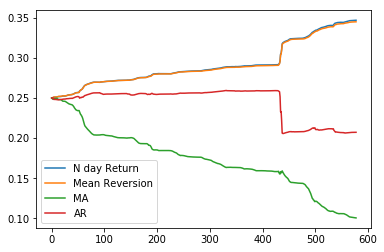

In [39]:
plt.plot(w_nd)
plt.plot(w_ou)
plt.plot(w_ma)
plt.plot(w_ar)
plt.legend(['N day Return', 'Mean Reversion','MA','AR'])
plt.show()

The Second Regret

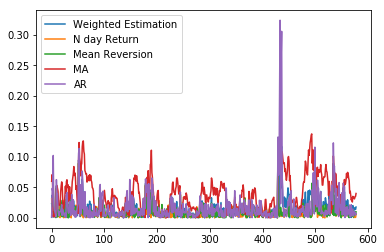

Average regret of Weighted Estimation is [ 0.35140076]
Average regret of N day Return is [ 0.57530078]
Average regret of Mean Reversion is [ 0.77934069]
Average regret of Moving Average is [ 0.08794055]
Average regret of AutoRegression is [ 0.08049976]


In [40]:
WEst = np.zeros(T-N_day)
reg_ar = [0]
reg_ma = [0]
reg_nd = [0]
reg_ou = [0]
reg_we = [0]
w_nd=[]
w_ou=[]
w_ar=[]
w_ma=[]
for t in range(T-N_day):
    w_nd.append(np.exp(-reg_nd[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    w_ou.append(np.exp(-reg_ou[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    w_ar.append(np.exp(-reg_ar[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    w_ma.append(np.exp(-reg_ma[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    WEst[t] = w_nd[t]*S_nd[t] + w_ou[t]*S_ou[t]+w_ar[t]*S_ar[t] + w_ma[t]*S_ma[t]
    #simulate investment
    if t < T-N_day-1:
        reg_nd += -np.sign(S_nd[t]-LogSt[t+N_day])*(St[t+N_day+1]-St[t+N_day])/1000
        reg_ou += -np.sign(S_ou[t]-LogSt[t+N_day])*(St[t+N_day+1]-St[t+N_day])/1000
        reg_ar += -np.sign(S_ar[t]-LogSt[t+N_day])*(St[t+N_day+1]-St[t+N_day])/1000
        reg_ma += -np.sign(S_ma[t]-LogSt[t+N_day])*(St[t+N_day+1]-St[t+N_day])/1000
        reg_we += -np.sign(WEst[t]-LogSt[t+N_day])*(St[t+N_day+1]-St[t+N_day])/1000

plt.plot(abs(WEst-np.array(X[N_day:])))
plt.plot(abs(S_nd-np.array(X[N_day:])))
plt.plot(abs(S_ou-np.array(X[N_day:])))
plt.plot(abs(S_ma-np.array(X[N_day:])))
plt.plot(abs(S_ar-np.array(X[N_day:])))
plt.legend(['Weighted Estimation', 'N day Return', 'Mean Reversion','MA','AR'])
plt.show()
print('Average regret of Weighted Estimation is',reg_we)
print('Average regret of N day Return is',reg_nd)
print('Average regret of Mean Reversion is',reg_ou)
print('Average regret of Moving Average is',reg_ma)
print('Average regret of AutoRegression is',reg_ar)

Plot weights over time.

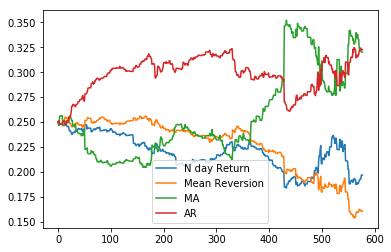

In [41]:
plt.plot(w_nd)
plt.plot(w_ou)
plt.plot(w_ma)
plt.plot(w_ar)
plt.legend(['N day Return', 'Mean Reversion','MA','AR'])
plt.show()